<a href="https://www.kaggle.com/code/tarekyahia/fine-tune-approach?scriptVersionId=160043460" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### we have tow approaches :
- #### first : 
    -  fine-tuning with transformers
    -  useing best practice hyperpramters from other comptitions wthout tuning them (i like to spend more time with the second approach^^) 
    -  working more and more with the inputs and the data that will finetune with.
    -  testing coustom loss function, pearson correlation, worked well with the first eboach only!, need more debug but the same was worked with the pytorch model.
    -  working with the task as a classification task with only one label.
    
- ### second approach:
    -  taking the last hidden state of the encoder based model ( like debarta ) then build some layears like an decoder above it.
    -  training the whole model with hyperpramters that were tuning well
    -  using custom loss function with some tricks, pearson correlation (pearson correlation is the evaluate metric of the competition) worked better than BCEWithLogitsLoss
    -  using AWP from the third eboach
    -  using attention pooling and an initialization weights that worked better than the default
    -  shuffle a part of the input sequence (for every example) in every traing step (the trick worked well in the cross validation score)
    -  a trick for GPU limitations when working with bigger models and more long input sequnces :
        -  in every batch, declare different max_len for the tokenizar based on the max input length in this batch, after sorting the df, this trick make me able to use deberta-v3-large with a long sequnce inputs and batch size = 4 
    -  last save the best models from every training (the best score on the validation set for every fold), then averaging them.
- ### general tricks :
    -  i use StratifiedGroupKFold for cross validation for two reasons, first the data was groubed by the anchor (very important note), second the data is imbalance.
    -  adding related data from other sources
    -  groupby(['anchor', 'context'])['target'] added to the input 
    - [link of the notebook](https://www.kaggle.com/code/tarekyahia/feature-extraction-approach) 
- ### tricks i want to implement in the comming version :
    -  work more with the nn model, test add bi-lstm and test more tricks in this point.
    -  save the best models from the first approach and use in the final subbmission else.
    -  test different and bigger LLM anc combine the results of the best in more robust way than just averaging.
    -  freaze almost all deberta layers, and almost work only with the "decoder" part.


In [1]:
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
import re
import random
import os
from sklearn.model_selection import StratifiedGroupKFold,GroupKFold,KFold
import torch
import torch.nn.functional as F
from torch import nn 
from datasets import Dataset,DatasetDict,Value
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW
from datasets import DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import TrainingArguments,Trainer
from transformers import AutoTokenizer, AutoModel, AutoConfig
from copy import deepcopy
from torch.nn.functional import cross_entropy



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# CFG
class CFG:
    n_fold = 5 
    trn_fold = 2
    batch_size = 8
    epochs = 5
    seed = 42
    model_id = "/kaggle/input/debertav3base"
    lr = 8e-5
    weight_decay = 0.01
    num_workers = 4
    gradient_accumulation_steps = 2
    
tokenizer = AutoTokenizer.from_pretrained(CFG.model_id)
CFG.tokenizer = tokenizer

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
# TO SAVE THE MODELS IF NEEDED 
if not os.path.exists('models'):
    os.makedirs('models')
OUTPUT_DIR = '/kaggle/working/models/'

In [4]:
train = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
#train = train.sample(50).reset_index()
test = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
display(train.head())
display(test.head())

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [5]:
# RELATED DATA
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    '''
    return : Dictionary
    '''
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results

In [6]:
cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)

In [7]:
train.head()

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


In [8]:
# groub by the anchor and context and add them to the inputs

targets = train.groupby(['anchor', 'context'])['target'].apply(list).reset_index(name='targets')
train = pd.merge(train, targets, on=['anchor','context'], how='inner') # join
train['targets_list'] = train.apply(lambda row: [item for item in row['targets'] if item != row['target']], axis=1) # delete 
train['n_targets'] = train.targets.apply(len) # for sorting if needed
train['targets'] = train.targets_list.apply(lambda l: '; '.join(l)) # add ; from list to one row , do it in the Dataset class
# new input for sorting only, i will make this combination again in the Dataset class to apply the shuffle trick
train['inputs'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']  + '[SEP]' + train['targets']
train.head()

,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,act of abating; active catalyst; eliminating p...,"[act of abating, active catalyst, eliminating ...",21,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement of pollution; active catalyst; elimi...,"[abatement of pollution, active catalyst, elim...",21,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement of pollution; act of abating; elimin...,"[abatement of pollution, act of abating, elimi...",21,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement of pollution; act of abating; active...,"[abatement of pollution, act of abating, activ...",21,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement of pollution; act of abating; active...,"[abatement of pollution, act of abating, activ...",21,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


In [9]:
# do the same to the test data

targets = test.groupby(['anchor', 'context'])['target'].apply(list).reset_index(name='targets')
test = pd.merge(test, targets, on=['anchor','context'], how='inner') # join
test['targets_list'] = test.apply(lambda row: [item for item in row['targets'] if item != row['target']], axis=1) # delete the current target from the list
test['n_targets'] = test.targets.apply(len) # not important
test['targets'] = test.targets_list.apply(lambda l: '; '.join(l)) # add ; from list to one row
# new input
test['inputs'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text'] + '[SEP]' + test['targets'] # prepare for predicting
test.head()

,id,anchor,target,context,context_text,targets,targets_list,n_targets,inputs
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,,[],1,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,,[],1,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,,[],1,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,,[],1,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,,[],1,neural stimulation[SEP]artificial neural netwo...


In [10]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4}) # for the Stratified ( convert to int )
Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'],train['anchor'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7334
1    6945
2    7271
3    7399
4    7524
dtype: int64

> sort the df then cutting it to batches, for tokenize every batch with the max lens of them, \
> another solution : loop over every batch in the training loop, i think is easier, but i implement this approach and i love to use it^^.

In [11]:
# batch max_len to overcome the GPU limitations problem
def tokenize_text(text):
    '''
    tokenize to sorting purpose
    '''
    inputs = CFG.tokenizer(text,
                           add_special_tokens=True,
                #           max_length=CFG.max_len,
                 #          padding="max_length",
                          # return_token_type_ids = False,
                          # return_attention_mask = False,
                           return_offsets_mapping=False) # pass only text
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs   


def sort_df_batch_lens(df,bs):
    '''
    sort df by the inputs tokenize count then add specific max len for every batch, instead of the max_len for all, this is more and more efficient to the GPU ram 
    '''
    
    dst_df = deepcopy(df)

    # sort by token num
    length = [len(tokenize_text(inputs)['input_ids']) for inputs in dst_df['inputs']]
    
    #   length = len(tokenizer(text, context_text, add_special_tokens=True)['input_ids'])
    #   input_lengths.append(length)   
    dst_df['input_lengths'] = length
    #print(dst_df['input_lengths'])
    length_sorted_idx = np.argsort([-l for l in length])
    
    # sort dataframe
    sort_df = dst_df.iloc[length_sorted_idx].copy()

    # calc max_len per batch
    sorted_input_length = sort_df['input_lengths'].values
    batch_max_length = np.zeros_like(sorted_input_length)
    for i in range((len(sorted_input_length)//bs)+1):
        if len(sorted_input_length[i*bs:(i+1)*bs]) != 0: # solve issue, in some batches the array is empty
            CFG.last_batch_max_len = np.max(sorted_input_length[i*bs:(i+1)*bs])
        batch_max_length[i*bs:(i+1)*bs] = CFG.last_batch_max_len # last batch if the array is empty
    sort_df['batch_max_length'] = batch_max_length
    
    return sort_df

In [12]:
# df -> Dataset
def prepare_text(cfg,text,batch_len):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=batch_len,
                           padding="max_length",
                         #  padding=True, # if i pass batches with map function and be batch = True, but i use Dataset class
                         #  truncation=True,
                           return_offsets_mapping=False) # pass only text
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs   

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, df):
        # super(TrainDataset, self).__init__(self)
        self.cfg = cfg
        self.batch_max_len = df['batch_max_length'].values
        # self.texts = df['inputs'].values
        self.anchor = df['anchor'].values
        self.targets_list = df['targets_list'].values
        self.context_text = df['context_text'].values
        self.target = df['target'].values
        self.sep = '[SEP]'
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        
        # the targets is shared with very little change for every group, shuffle is a trick 
        # shuffle in-place every call 
        random.shuffle(self.targets_list[item])
        self.targets = '; '.join(self.targets_list[item]) # from list to one long string
        
        self.input = self.anchor[item] + self.sep + self.target[item] + self.sep  + self.context_text[item]  + self.sep + self.targets # the item input

        inputs = prepare_text(self.cfg, self.input,self.batch_max_len[item])
        inputs['label'] = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs

In [13]:
# evaluation metric
def corr(eval_pred): 
    return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [14]:
# reinitializing every new training in the validation folds
def reinitializing_model():
    return AutoModelForSequenceClassification.from_pretrained(CFG.model_id, num_labels=1)

In [15]:
def get_trainer(train_dataset,valid_dataset,fold):
    """
    merge the suitable pre-trained model architecture with some best use hyperparameters with the data 
    """
    
    # reinitializing the instante model to prevent data leakage
    CFG.model = reinitializing_model()
    
    
   # model_name = f"{CFG.model_id}-finetuned-{fold}"
    
    args = TrainingArguments(OUTPUT_DIR,learning_rate=CFG.lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
          evaluation_strategy='epoch', per_device_train_batch_size=CFG.batch_size, per_device_eval_batch_size=CFG.batch_size*2,
           num_train_epochs=CFG.epochs, weight_decay=CFG.weight_decay, report_to='none',
                             gradient_accumulation_steps = CFG.gradient_accumulation_steps,save_strategy = "no") 
    
    
    return Trainer(CFG.model, args, train_dataset=train_dataset,eval_dataset=valid_dataset,
                   tokenizer=CFG.tokenizer, compute_metrics=corr)

In [16]:
def train_loop(folds, fold):
    # ====================================================
    # fine-tune
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    
    # batched and sorted for GPU limitation
    train_folds = sort_df_batch_lens(train_folds,CFG.batch_size)
    valid_folds = sort_df_batch_lens(valid_folds,CFG.batch_size)
    valid_labels = valid_folds['score'].values
    
    
    train_dataset = TrainDataset(CFG,train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    model = get_trainer(train_dataset,valid_dataset,fold)
    model.train()
    
    preds = model.predict(valid_dataset).predictions.astype(float).flatten()
    valid_folds['pred'] = preds

        
    return valid_folds,model

In [17]:
# on the all folds
oof_df = pd.DataFrame()
for fold in range(CFG.n_fold):
    _oof_df,model = train_loop(train, fold)
    oof_df = pd.concat([oof_df, _oof_df])
oof_df = oof_df.reset_index(drop=True)
print(f"results = {np.corrcoef(oof_df['score'] ,oof_df['pred'] )[0][1]}")
oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
0,0.030800,0.026271,0.783133
2,0.013000,0.022515,0.825457
4,0.005700,0.022174,0.827556


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Pearson
0,0.031800,0.026863,0.769438
2,0.013300,0.024353,0.810199
4,0.005800,0.023200,0.817683


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Pearson
0,0.030200,0.029932,0.744274
2,0.013000,0.023056,0.811657
4,0.006100,0.023042,0.819109


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Pearson
0,0.029900,0.029184,0.778284
2,0.067500,0.065401,nan
4,0.068000,0.065316,nan


/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Pearson
0,0.031700,0.025592,0.793676
2,0.013500,0.023029,0.838639
4,0.005600,0.020990,0.844753


results = 0.7408903966349055


In [18]:
print(f"results = {np.corrcoef(oof_df['score'] ,oof_df['pred'] )[0][1]}")
oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')

results = 0.7408903966349055


### error analysis

In [19]:

oof_df.head()

,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs,score_map,fold,input_lengths,batch_max_length,pred
0,78c64a6188273d7c,reflection type liquid crystal display,reflection liquid crystal,G02,0.50,PHYSICS. OPTICS,bright crystal device; bright crystal display;...,"[reflection mode lcd crystal, liquid crystal l...",84,reflection type liquid crystal display[SEP]ref...,2,0,393,393,0.338379
1,8822b980ccceb495,reflection type liquid crystal display,camouflaged structure,G02,0.25,PHYSICS. OPTICS,bright crystal device; bright crystal display;...,"[reflection type display, reflection matrix cr...",84,reflection type liquid crystal display[SEP]cam...,1,0,393,393,0.226074
2,b48c3786ceac77d6,reflection type liquid crystal display,color liquid crystal display device,G02,0.50,PHYSICS. OPTICS,bright crystal device; bright crystal display;...,"[reflection type liquid, liquid matrix type li...",84,reflection type liquid crystal display[SEP]col...,2,0,393,393,0.504395
3,b35cfc5f8de4d14a,reflection type liquid crystal display,crystal ball,G02,0.00,PHYSICS. OPTICS,bright crystal device; bright crystal display;...,"[liquid meter, reflective type liquid crystal,...",84,reflection type liquid crystal display[SEP]cry...,0,0,393,393,-0.011925
4,fa89d02b9f0577ec,reflection type liquid crystal display,display cabinet,G02,0.00,PHYSICS. OPTICS,bright crystal device; bright crystal display;...,"[reflective mode liquid crystal display, liqui...",84,reflection type liquid crystal display[SEP]dis...,0,0,393,393,-0.005154


In [20]:
# oof_df = pd.read_pickle('/kaggle/input/validationdataset/oof_df.pkl')

In [21]:
# some values less than zeros and bigger than one
# if we clip, the metric will increase ? 
print(f"results = {np.corrcoef(oof_df['score'] ,oof_df['pred'].clip(0, 1))[0][1]}")

results = 0.7398089602718849


In [22]:
# clip 
oof_df['pred'] = oof_df['pred'].clip(0, 1)

# loss between the target and predict ( this way to calculate the loss for an intuition about the errors only )
oof_df['loss'] = (oof_df['score'] - oof_df['pred']).abs()

# sort by loss
# most loss
oof_df.sort_values("loss", ascending=False).head(10)

,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs,score_map,fold,input_lengths,batch_max_length,pred,loss
7117,7c58de81e26d5788,annular neck,annual neck,B65,1.00,PERFORMING OPERATIONS; TRANSPORTING. CONVEYING...,annular flange; aperture; neck; opening,"[annular flange, neck, opening, aperture]",5,annular neck[SEP]annual neck[SEP]PERFORMING OP...,4,0,44,46,0.006176,0.993824
14580,f297ea79eab86071,boom hydraulic cylinder,boom a hydraulic cylinder,E02,0.00,FIXED CONSTRUCTIONS. HYDRAULIC ENGINEERING; FO...,actuator; actuator cylinder; air pressure tool...,"[gas cylinder, bucket hydraulic cylinder, boom...",58,boom hydraulic cylinder[SEP]boom a hydraulic c...,0,2,222,222,0.992188,0.992188
44,e2c8b118edcfcb84,reflection type liquid crystal display,reflective type liquid display,G02,0.00,PHYSICS. OPTICS,bright crystal device; bright crystal display;...,"[reflection mode liquid display, liquid type c...",84,reflection type liquid crystal display[SEP]ref...,0,0,393,393,0.789062,0.789062
4334,6ffb2bf0b2fa6d62,pictorial image,pictorial representation,G09,0.00,PHYSICS. EDUCATION; CRYPTOGRAPHY; DISPLAY; ADV...,background; carbon copy; character; component;...,"[character, plain image, computer graphic imag...",28,pictorial image[SEP]pictorial representation[S...,0,0,106,106,0.769043,0.769043
35967,5ad513a964e9d0a6,dissolving,dissolution,C22,0.00,HEMISTRY; METALLURGY. METALLURGY; FERROUS OR N...,diffuse; disadvantage; disengagement; dislike;...,"[dissolving capacity, solid, disadvantage, sol...",15,dissolving[SEP]dissolution[SEP]HEMISTRY; METAL...,0,4,74,74,0.760254,0.760254
29600,20a45b67a785caf3,imaging axis,imaging of axis,G02,0.00,PHYSICS. OPTICS,apparatus method; arc; arm; axial imaging; axi...,"[axis net, axis, photographic apparatus, arm, ...",48,imaging axis[SEP]imaging of axis[SEP]PHYSICS. ...,0,4,171,171,0.758301,0.758301
15529,9cb8961d472be828,offset table,offset map,H04,0.75,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,bias current table; billiard table; color conv...,"[offset memory, table glass, correction storin...",44,offset table[SEP]offset map[SEP]ELECTRICITY. E...,3,2,163,163,0.000000,0.750000
11706,0b075573f8e672d0,connecting lines,connecting bus,H05,0.75,ELECTRICITY. ELECTRIC TECHNIQUES NOT OTHERWISE...,actuating leads; cables; connecting roads; con...,"[connecting words, operating lines, wire conne...",32,connecting lines[SEP]connecting bus[SEP]ELECTR...,3,1,105,105,0.000000,0.750000
18361,30149fe4d20947fe,hanging ring,exercise rings,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,bell ring; boxing ring; circlet portion; circu...,"[hanging loop, metal clips, circuit portion, r...",23,hanging ring[SEP]exercise rings[SEP]HUMAN NECE...,3,2,108,108,0.000000,0.750000
12092,9b188e680245e656,connecting lines,connecting bus,H01,0.75,ELECTRICITY. BASIC ELECTRIC ELEMENTS,auxiliary windings; connected devices; connect...,"[electric connecting lines, connecting jumpers...",30,connecting lines[SEP]connecting bus[SEP]ELECTR...,3,1,99,99,0.000000,0.750000


In [23]:
# most accurate
oof_df.sort_values("loss", ascending=True).head(10)

,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs,score_map,fold,input_lengths,batch_max_length,pred,loss
18236,e0318d32a94520d7,sensitive photographic,sensitive plant,H01,0.0,ELECTRICITY. BASIC ELECTRIC ELEMENTS,blur image; camera film; camera recording; chr...,"[sensitive imaging, blur image, colour sensiti...",30,sensitive photographic[SEP]sensitive plant[SEP...,0,2,108,108,0.0,0.0
10260,87434cad3cb043f8,feed control valve,video feed,F41,0.0,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,boiler; cattle feed; control chart; control va...,"[input control valve, feed water valve, variab...",29,feed control valve[SEP]video feed[SEP]MECHANIC...,0,1,122,122,0.0,0.0
10259,049269495364a78d,transition member,transition member,F02,1.0,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,communication mode transition; conference memb...,"[exhaust tube, transition, conference members,...",26,transition member[SEP]transition member[SEP]ME...,4,1,122,122,1.0,0.0
35347,f326de7e7b03f94a,inner closed,inner voice,E04,0.0,FIXED CONSTRUCTIONS. BUILDING,closed inner end; closed place; closed reducti...,"[inner coupling member, inner join, container,...",24,inner closed[SEP]inner voice[SEP]FIXED CONSTRU...,0,4,88,88,0.0,0.0
10257,10deae6804d418f1,feed control valve,cattle feed,F41,0.0,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,boiler; control chart; control valve; dream fe...,"[rammer control valve, operating control valve...",29,feed control valve[SEP]cattle feed[SEP]MECHANI...,0,1,122,122,0.0,0.0
3003,b36f4342519e46aa,shift link,shift key,A47,0.0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,control rod; evening shift; gear level; gear s...,"[night shift, shift rod lever link, morning sh...",24,shift link[SEP]shift key[SEP]HUMAN NECESSITIES...,0,0,119,120,0.0,0.0
3004,e01731d390bb9846,shift link,temperature shift,A47,0.0,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,control rod; evening shift; gear level; gear s...,"[shift, shifting linkage mechanism, lever mech...",24,shift link[SEP]temperature shift[SEP]HUMAN NEC...,0,0,119,120,0.0,0.0
10256,d4422588553766d1,feed control valve,control chart,F41,0.0,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,boiler; cattle feed; control valve; dream feed...,"[trigger rod, feed control valves, steam gener...",29,feed control valve[SEP]control chart[SEP]MECHA...,0,1,122,122,0.0,0.0
10254,af02afb83f734fc6,feed control valve,dream feed,F41,0.0,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,boiler; cattle feed; control chart; control va...,"[flow control valve, rammer control valve, ste...",29,feed control valve[SEP]dream feed[SEP]MECHANIC...,0,1,122,122,0.0,0.0
10253,49d86f1dc18e70f5,feed control valve,feed control valves,F41,1.0,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,boiler; cattle feed; control chart; control va...,"[feed water valve, online feed, hydraulic mach...",29,feed control valve[SEP]feed control valves[SEP...,4,1,122,122,1.0,0.0


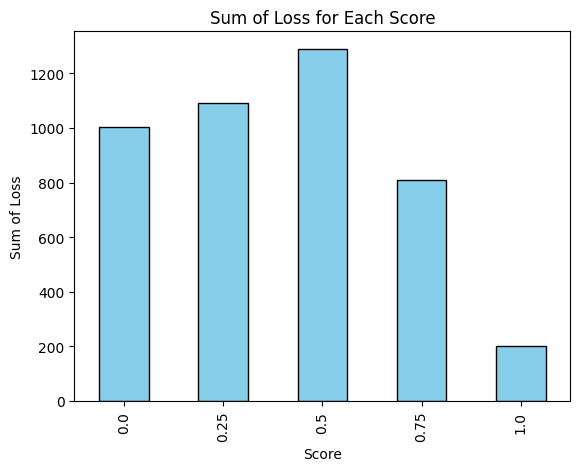

In [24]:
# loss per class
oof_df.groupby(['score'])['loss'].sum().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Sum of Loss')
plt.title('Sum of Loss for Each Score')
plt.show()

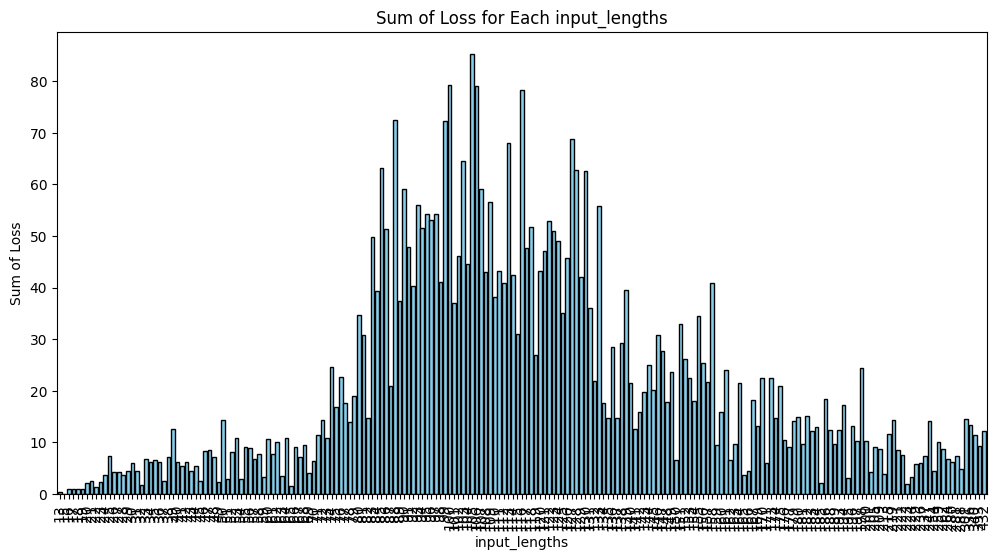

In [25]:
# relation between input lens and the loss 
# loss per input lens
plt.figure(figsize=(12, 6))
ax  = oof_df.groupby(['input_lengths'])['loss'].sum().plot(kind='bar', color='skyblue', edgecolor='black',width=0.8)
plt.xlabel('input_lengths')
plt.ylabel('Sum of Loss')
plt.title('Sum of Loss for Each input_lengths')
plt.show()

> we can go more and more to understand the errores and the ability to avoid them.

### submission

> in the comming versions we can do :  
- save best models and ensample.
- train in the all dataset.
> 

In [26]:
# use it for testing only, TODO : edit it

def tok_func(x):  return CFG.tokenizer(x["inputs"], padding=True, truncation=True) # padding true to work with the max len in the batch

test = Dataset.from_pandas(test).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [27]:
preds = model.predict(test).predictions.astype(float).flatten()

In [28]:
preds = np.clip(preds, 0, 1)

In [29]:
submission = Dataset.from_dict({
    'id': test['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1065

In [30]:
submission

Dataset({
    features: ['id', 'score'],
    num_rows: 36
})